# ResNet

In [1]:
import pandas as pd
import numpy as np
import os
import time
import random
from PIL import Image
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import timm
import torch
import albumentations as A
import torch.nn as nn
from albumentations.pytorch import ToTensorV2
from torch.optim import Adam
from torchvision import transforms
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import accuracy_score, f1_score

import wandb

In [2]:
# 시드를 고정합니다.
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
device

device(type='cuda')

# CustomDataset

In [5]:
class customdataset(torch.utils.data.Dataset):
    def __init__(self, csv, path, transforms):
        super().__init__()
        self.df = pd.read_csv(csv).values
        self.path = path
        self.transforms = transforms

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        name, target = self.df[idx]
        img = np.array(Image.open(os.path.join(self.path, name)))
        img = self.transforms(img)
    
        return img, target

In [6]:
'''
class GaussianNoise:
    def __init__(self, mean, std_range):
        self.mean = mean
        self.std_range = std_range

    def __call__(self, tensor):
        std = random.uniform(*self.std_range)
        noise = torch.randn(tensor.size())*std + self.mean
        return tensor + noise
'''

class RandomPadding:
    def __init__(self, padding_range=(0, 50), fill=0):
        self.padding_range = padding_range
        self.fill = fill

    def __call__(self, image):
        # 각 방향에 대해 랜덤한 패딩 값 생성
        pad_top = random.randint(*self.padding_range)
        pad_bottom = random.randint(*self.padding_range)
        pad_left = random.randint(*self.padding_range)
        pad_right = random.randint(*self.padding_range)
        
        # 패딩 추가
        padding = (pad_left, pad_top, pad_right, pad_bottom)
        return T.functional.pad(image, padding, fill=self.fill)

'''
# 랜덤 정규화 변환 클래스
class RandomNormalize:
    def __init__(self, mean_range, std_range):
        self.mean_range = mean_range
        self.std_range = std_range

    def __call__(self, tensor):
        # 각 채널에 대한 랜덤한 mean과 std 생성
        mean = [random.uniform(*self.mean_range) for _ in range(3)]
        std = [random.uniform(*self.std_range) for _ in range(3)]
        # 정규화 적용
        tensor = T.functional.normalize(tensor, mean=mean, std=std)
        return tensor
'''

'\n# 랜덤 정규화 변환 클래스\nclass RandomNormalize:\n    def __init__(self, mean_range, std_range):\n        self.mean_range = mean_range\n        self.std_range = std_range\n\n    def __call__(self, tensor):\n        # 각 채널에 대한 랜덤한 mean과 std 생성\n        mean = [random.uniform(*self.mean_range) for _ in range(3)]\n        std = [random.uniform(*self.std_range) for _ in range(3)]\n        # 정규화 적용\n        tensor = T.functional.normalize(tensor, mean=mean, std=std)\n        return tensor\n'

In [7]:
aug_transforms = T.Compose([
    T.ToTensor(),
    T.RandomRotation(180),
    T.RandomHorizontalFlip(p=0.5),
    RandomPadding(padding_range=(10, 20), fill=50),  # 랜덤 패딩 추가
    T.RandomResizedCrop(size=(600,600), scale=(0.5, 1.0)),
])

simple_transforms = T.Compose([
    T.ToTensor(),
    T.RandomRotation(180),
    T.RandomHorizontalFlip(p=0.5),
    T.Resize((600, 600))
])

origin_transforms = T.Compose([
    T.ToTensor(),
    T.Resize((600, 600))
    ])

aug_dataset_1 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/Augmentation/augraphy/augmented', transforms=aug_transforms)
aug_dataset_2 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/Augmentation/augraphy/augmented2', transforms=aug_transforms)
aug_dataset_3 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/Augmentation/augraphy/augmented3', transforms=aug_transforms)
aug_dataset_4 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/Augmentation/augraphy/augmented4', transforms=aug_transforms)
aug_dataset_5 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/Augmentation/augraphy/augmented5', transforms=aug_transforms)
aug_dataset_6 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/Augmentation/augraphy/augmented6', transforms=aug_transforms)
aug_dataset_7 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/Augmentation/augraphy/augmented7', transforms=aug_transforms)
aug_dataset_8 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/Augmentation/augraphy/augmented8', transforms=aug_transforms)
aug_dataset_9 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/Augmentation/augraphy/augmented9', transforms=aug_transforms)
aug_dataset_10 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/Augmentation/augraphy/augmented10', transforms=aug_transforms) # v.1.3
aug_dataset_11 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/Augmentation/augraphy/augmented11', transforms=aug_transforms)
aug_dataset_12 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/Augmentation/augraphy/augmented12', transforms=aug_transforms)
aug_dataset_13 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/Augmentation/augraphy/augmented13', transforms=aug_transforms)
aug_dataset_14 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/Augmentation/augraphy/augmented14', transforms=aug_transforms)
aug_dataset_15 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/Augmentation/augraphy/augmented15', transforms=aug_transforms)
aug_dataset_16 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/Augmentation/augraphy/augmented16', transforms=aug_transforms)
aug_dataset_17 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/Augmentation/augraphy/augmented17', transforms=aug_transforms)
aug_dataset_18 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/Augmentation/augraphy/augmented18', transforms=aug_transforms)
aug_dataset_19 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/Augmentation/augraphy/augmented19', transforms=aug_transforms)
aug_dataset_20 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/Augmentation/augraphy/augmented20', transforms=aug_transforms)
aug_dataset_21 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/Augmentation/augraphy/augmented21', transforms=aug_transforms)
aug_dataset_22 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/Augmentation/augraphy/augmented22', transforms=aug_transforms)
aug_dataset_23 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/Augmentation/augraphy/augmented23', transforms=aug_transforms)
aug_dataset_24 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/Augmentation/augraphy/augmented24', transforms=aug_transforms)
aug_dataset_25 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/Augmentation/augraphy/augmented25', transforms=aug_transforms)# v.1.4 & v.1.5

simple_aug_dataset_1 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/train/', transforms=simple_transforms)
simple_aug_dataset_2 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/train/', transforms=simple_transforms)
simple_aug_dataset_3 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/train/', transforms=simple_transforms)
simple_aug_dataset_4 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/train/', transforms=simple_transforms)
simple_aug_dataset_5 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/train/', transforms=simple_transforms) # v.1.3
simple_aug_dataset_6 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/train/', transforms=simple_transforms)
simple_aug_dataset_7 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/train/', transforms=simple_transforms)
simple_aug_dataset_8 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/train/', transforms=simple_transforms)
simple_aug_dataset_9 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/train/', transforms=simple_transforms)
simple_aug_dataset_10 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/train/', transforms=simple_transforms) # v.1.4
simple_aug_dataset_11 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/train/', transforms=simple_transforms)
simple_aug_dataset_12 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/train/', transforms=simple_transforms)
simple_aug_dataset_13 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/train/', transforms=simple_transforms)
simple_aug_dataset_14 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/train/', transforms=simple_transforms)
simple_aug_dataset_15 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/train/', transforms=simple_transforms)
simple_aug_dataset_16 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/train/', transforms=simple_transforms)
simple_aug_dataset_17 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/train/', transforms=simple_transforms)
simple_aug_dataset_18 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/train/', transforms=simple_transforms)
simple_aug_dataset_19 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/train/', transforms=simple_transforms)
simple_aug_dataset_20 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/train/', transforms=simple_transforms) # v.1.5

origin_dataset_1 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/train/', transforms=origin_transforms) # v.1 ~ v.1.4
origin_dataset_2 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/train/', transforms=origin_transforms)
origin_dataset_3 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/train/', transforms=origin_transforms)
origin_dataset_4 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/train/', transforms=origin_transforms)
origin_dataset_5 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/train/', transforms=origin_transforms)
origin_dataset_6 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/train/', transforms=origin_transforms) # v.1.5

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..50.0].


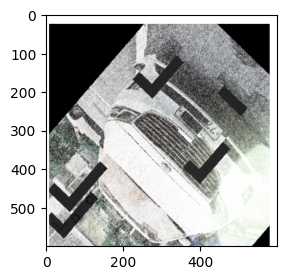

In [8]:
plt.figure(figsize=(3, 3))
plt.imshow(aug_dataset_18[0][0].permute(1, 2, 0))
plt.show()

In [9]:
total_dataset = torch.utils.data.ConcatDataset([aug_dataset_1, aug_dataset_2, aug_dataset_3, 
                                                aug_dataset_4, aug_dataset_5, aug_dataset_6, 
                                                aug_dataset_7, aug_dataset_8, aug_dataset_9, 
                                                aug_dataset_10, aug_dataset_11, aug_dataset_12,
                                                aug_dataset_13, aug_dataset_14, aug_dataset_15,
                                                aug_dataset_16, aug_dataset_17, aug_dataset_18,
                                                aug_dataset_19, aug_dataset_20, aug_dataset_21,
                                                aug_dataset_22, aug_dataset_23, aug_dataset_24, aug_dataset_25,

                                                simple_aug_dataset_1, simple_aug_dataset_2, simple_aug_dataset_3,
                                                simple_aug_dataset_4, simple_aug_dataset_5, simple_aug_dataset_6,
                                                simple_aug_dataset_7, simple_aug_dataset_8, simple_aug_dataset_9, 
                                                simple_aug_dataset_10, simple_aug_dataset_11, simple_aug_dataset_12,
                                                simple_aug_dataset_13, simple_aug_dataset_14, simple_aug_dataset_15,
                                                simple_aug_dataset_16, simple_aug_dataset_17, simple_aug_dataset_18,
                                                simple_aug_dataset_19, simple_aug_dataset_20,

                                                origin_dataset_1, origin_dataset_2, origin_dataset_3,
                                                origin_dataset_4, origin_dataset_5, origin_dataset_6])

In [10]:
total_num = len(total_dataset)
train_num, valid_num, test_num = int(total_num*0.8), int(total_num*0.1), int(total_num*0.1)

train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(total_dataset, [train_num, valid_num, test_num])

print(len(train_dataset), len(valid_dataset), len(test_dataset))

64056 8007 8007


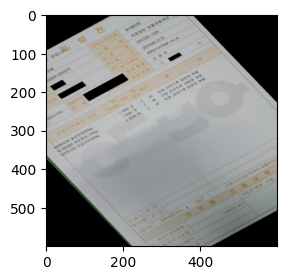

In [11]:
plt.figure(figsize=(3, 3))
plt.imshow(train_dataset[10][0].permute(1, 2, 0))
plt.show()

In [12]:
batch_size = 100

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True, num_workers=16)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size, shuffle=False, num_workers=16)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle=False, num_workers=16)

# 학습

In [13]:
def training(model, train_dataloader, train_dataset, criterion, optimizer, epoch, num_epochs):
    model.train()
    train_loss = 0.0
    train_accuracy = 0

    tbar = tqdm(train_dataloader)
    for images, labels in tbar:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        max_prob, predicted = torch.max(outputs, 1)
        train_accuracy += (predicted == labels).sum().item()

        tbar.set_description(f'Epoch/Epochs [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}')

    train_loss = train_loss / len(train_dataloader)
    train_accuracy = train_accuracy / len(train_dataset)

    return model, train_loss, train_accuracy

def evalutaion(model, valid_dataloader, valid_accuracy, criterion, epoch, num_epochs):
    model.eval()
    valid_loss = 0.0
    valid_accuracy = 0

    with torch.no_grad():
        tbar = tqdm(valid_dataloader)
        for images, labels in tbar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            valid_loss += loss.item()
            max_prob, predicted = torch.max(outputs, 1)
            valid_accuracy += (predicted == labels).sum().item()

            tbar.set_description(f'Epoch/Epochs [{epoch+1}/{num_epochs}], Valid Loss: {loss.item():.4f}')

    valid_loss = valid_loss / len(valid_dataloader)
    valid_accuracy = valid_accuracy / len(valid_dataset)

    return model, valid_loss, valid_accuracy

def training_loop(model, train_dataloader, train_dataset, valid_dataloader, valid_dataset, criterion, optimizer, num_epochs):
    best_valid_loss = float('inf')
    early_stop_cnt = 0
    valid_max_accuracy = -1

    for epoch in range(num_epochs):
        model, train_loss, train_accuracy = training(model, train_dataloader, train_dataset, criterion, optimizer, epoch, num_epochs)
        model, valid_loss, valid_accuracy = evalutaion(model, valid_dataloader, valid_dataset, criterion, epoch, num_epochs)

        #monitoring_values = {'Train Loss': train_loss, 'Valid Loss': valid_loss, 'Train Accuracy': train_accuracy, 'Valid Accuracy': valid_accuracy}
        #run.log(monitoring_values, step=epoch)

        if valid_accuracy > valid_max_accuracy:
            valid_max_accuracy = valid_accuracy

        if valid_loss < best_valid_loss:
            torch.save(model.state_dict(), f"/data/ephemeral/home/model/models/model_v1_5.pt")
            best_valid_loss = valid_loss
            early_stop_cnt = 0

        else :
            early_stop_cnt += 1

        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f} Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.4f}")

        if early_stop_cnt >= 10:
            print('Early Stopping')
            break

    return model

In [14]:
model = timm.create_model(
    'resnet34',
    pretrained=True,
    num_classes=17
).to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [15]:
model = training_loop(model, train_dataloader, train_dataset, valid_dataloader, valid_dataset, criterion, optimizer, 100)

  0%|          | 0/641 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Epoch [1/100], Train Loss: 0.5200, Train Accuracy: 0.8241 Valid Loss: 0.2445, Valid Accuracy: 0.9152


  0%|          | 0/641 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Epoch [2/100], Train Loss: 0.1534, Train Accuracy: 0.9460 Valid Loss: 0.2404, Valid Accuracy: 0.9153


  0%|          | 0/641 [00:00<?, ?it/s]

KeyboardInterrupt: 

: 

In [ ]:
torch.save(model.state_dict(), f"/data/ephemeral/home/model/models/model_v1_3.pt") 

# Test

In [ ]:
model.eval()
test_loss = 0.0
test_accuracy = 0

all_preds = []

with torch.no_grad():
    tbar = tqdm(test_dataloader)
    for images, labels in tbar:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        test_loss += loss.item()
        max_prob, predicted = torch.max(outputs, 1)
        test_accuracy += (predicted == labels).sum().item()

        all_preds.extend(predicted)

test_loss = test_loss / len(test_dataloader)
test_accuracy = test_accuracy / len(test_dataset)

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

In [ ]:
plt.figure(figsize=(20, 20))

for i in range(20, 40):
    ax = plt.subplot(4, 5, (i%20)+1)

    plt.imshow(test_dataset[i][0].permute(1, 2, 0))
    plt.title(f'real: {test_dataset[i][1]}\npred: {all_preds[i].cpu()}')

# Submission

In [12]:
model = timm.create_model(
    'resnet34',
    pretrained=True,
    num_classes=17
).to(device)
model.load_state_dict(torch.load('/data/ephemeral/home/model/models/model_v1_4.pt'))
criterion = torch.nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [13]:
class sub_customdataset(torch.utils.data.Dataset):
    def __init__(self, csv, path, transforms):
        super().__init__()
        self.df = pd.read_csv(csv).values
        self.path = path
        self.transforms = transforms

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        name, target = self.df[idx]
        img = np.array(Image.open(os.path.join(self.path, name)))
        img = self.transforms(img)
    
        return img, target

In [14]:
transforms = T.Compose([
    T.ToTensor(),
    T.Resize((600, 600))
])

sub_dataset = sub_customdataset('/data/ephemeral/home/data/sample_submission.csv', '/data/ephemeral/home/data/test/', transforms=transforms)

In [15]:
batch_size = 64

sub_dataloader = torch.utils.data.DataLoader(sub_dataset, batch_size=batch_size, shuffle=False, num_workers=16)

In [16]:
model.eval()

all_preds = []
all_labels = []
all_images = []

with torch.no_grad():
    tbar = tqdm(sub_dataloader)
    for images, labels in tbar:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)

        max_prob, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted)
        all_labels.extend(labels)
        all_images.extend(images)


  0%|          | 0/50 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

In [17]:
all_preds

[tensor(2, device='cuda:0'),
 tensor(12, device='cuda:0'),
 tensor(5, device='cuda:0'),
 tensor(15, device='cuda:0'),
 tensor(2, device='cuda:0'),
 tensor(15, device='cuda:0'),
 tensor(0, device='cuda:0'),
 tensor(8, device='cuda:0'),
 tensor(15, device='cuda:0'),
 tensor(11, device='cuda:0'),
 tensor(5, device='cuda:0'),
 tensor(3, device='cuda:0'),
 tensor(16, device='cuda:0'),
 tensor(9, device='cuda:0'),
 tensor(15, device='cuda:0'),
 tensor(4, device='cuda:0'),
 tensor(7, device='cuda:0'),
 tensor(5, device='cuda:0'),
 tensor(13, device='cuda:0'),
 tensor(10, device='cuda:0'),
 tensor(12, device='cuda:0'),
 tensor(12, device='cuda:0'),
 tensor(1, device='cuda:0'),
 tensor(6, device='cuda:0'),
 tensor(3, device='cuda:0'),
 tensor(0, device='cuda:0'),
 tensor(7, device='cuda:0'),
 tensor(16, device='cuda:0'),
 tensor(12, device='cuda:0'),
 tensor(6, device='cuda:0'),
 tensor(3, device='cuda:0'),
 tensor(0, device='cuda:0'),
 tensor(13, device='cuda:0'),
 tensor(2, device='cuda:0'),


In [18]:
sub_df = pd.read_csv('/data/ephemeral/home/data/sample_submission.csv')
sub_df

,ID,target
0,0008fdb22ddce0ce.jpg,0
1,00091bffdffd83de.jpg,0
2,00396fbc1f6cc21d.jpg,0
3,00471f8038d9c4b6.jpg,0
4,00901f504008d884.jpg,0
...,...,...
3135,ffb4b6f619fb60ea.jpg,0
3136,ffb54299b1ad4159.jpg,0
3137,ffc2c91dff8cf2c0.jpg,0
3138,ffc4e330a5353a2a.jpg,0


In [19]:
for i in range(3140):
    sub_df.iloc[i, 1] = int(all_preds[i].cpu())

In [20]:
sub_df.to_csv('/data/ephemeral/home/preds/v1_4_preds.csv', index=False)